# Crear el archivo de entrada con datos meteorológicos considerando radiación

En este cuaderno aprenderás a crear datos de entrada para el modelo glaciológico. Usaremos datos meteorológicos y topográficos. Usaremos un método simple de interpolación para distribuir los datos en todo el glaciar. 

**Importante:** instalar un entorno para ejecutar **COSIPY** antes de correr este notebook.  
Puedes descargar el código de COSIPY desde [este enlace](https://github.com/cryohydromettools/cosipy/tree/master).

```bash
# Instalar un entorno Conda para COSIPY
sudo apt install build-essential

# Crear el entorno con las dependencias principales
conda create -n cosipy -c conda-forge python=3.10 gdal=3.9.0 numpy=2.0.0 netcdf4 hdf5 libnetcdf

# Activar el entorno
conda activate cosipy

# Instalar los requisitos adicionales
pip install -r requirements.txt


## Importar librerias **`xarray`** y **`numpy`**

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Leer datos

In [2]:
# Dominio
ds_sta = xr.open_dataset('../modulo11/dom/dom_AG.nc')
ds_sta

<xarray.Dataset> Size: 17kB
Dimensions:  (lon: 35, lat: 30)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...

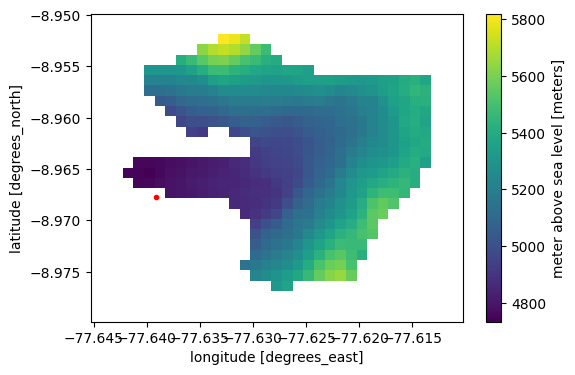

In [3]:
plt.figure(figsize=(6, 4))
ds_sta['HGT'].where(ds_sta['MASK']).plot()
plt.plot(-77.6391, -8.9677, 'r.')

In [4]:
filename = '../data/aws_AG_3h.csv'
df_aws   =  pd.read_csv(filename, sep='\t')
df_aws.TIMESTAMP = pd.to_datetime(df_aws.TIMESTAMP)
df_aws.set_index('TIMESTAMP', inplace=True)

In [5]:
df_aws_2016 = df_aws.loc['2016-08-15':'2017-09-10'][['Ta_Avg', 'precip_Tot', 'SWin_Avg']].rename(columns={'Ta_Avg':'T2', 'precip_Tot': 'RRR', 'SWin_Avg':'SWin'})

In [6]:
df_aws_2016

,T2,RRR,SWin
TIMESTAMP,,,
2016-08-15 00:00:00,1.969468,0.06,0.000000
2016-08-15 03:00:00,0.822943,0.00,0.000000
2016-08-15 06:00:00,0.253542,0.00,0.000000
2016-08-15 09:00:00,-0.378271,0.00,0.065144
2016-08-15 12:00:00,2.494230,0.03,376.263012
...,...,...,...
2017-09-10 09:00:00,-0.386536,0.00,1.369785
2017-09-10 12:00:00,2.292619,0.04,446.712697
2017-09-10 15:00:00,2.703987,0.03,549.304483


## Hacer una copia para guardar los datos de entrada

In [7]:
dso = ds_sta.copy()    
dso

<xarray.Dataset> Size: 17kB
Dimensions:  (lon: 35, lat: 30)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...

In [8]:
dso.coords['time'] = df_aws_2016.index.values
dso

<xarray.Dataset> Size: 42kB
Dimensions:  (lon: 35, lat: 30, time: 3136)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
  * time     (time) datetime64[ns] 25kB 2016-08-15 ... 2017-09-10T21:00:00
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...

## Interpolar las variables de temperatura y precipitación 

In [9]:
T_interp   = np.zeros([len(dso.time), len(ds_sta.lat), len(ds_sta.lon)])

In [10]:
lapse_T   = -6.5/1000 # °C / m
HGT_AWS   = 4800

In [11]:
T2 = df_aws_2016.T2.values

In [12]:
for t in range(len(dso.time)):
    T_interp[t,:,:] = T2[t] + (ds_sta.HGT.values - HGT_AWS) * lapse_T


## Crear una función para guardar los datos interpolados

In [13]:
def add_variable_along_timelatlon(ds, var, name, units, long_name):
    """ This function adds missing variables to the DATA class """
    ds[name] = (('time','lat','lon'), var)
    ds[name].attrs['units'] = units
    ds[name].attrs['long_name'] = long_name
    return ds

In [14]:
add_variable_along_timelatlon(dso, T_interp, 'T2', 'C', 'Temperature at 2 m')

<xarray.Dataset> Size: 26MB
Dimensions:  (lon: 35, lat: 30, time: 3136)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
  * time     (time) datetime64[ns] 25kB 2016-08-15 ... 2017-09-10T21:00:00
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...
    T2       (time, lat, lon) float64 26MB 5.089 4.94 4.498 ... 2.415 2.201

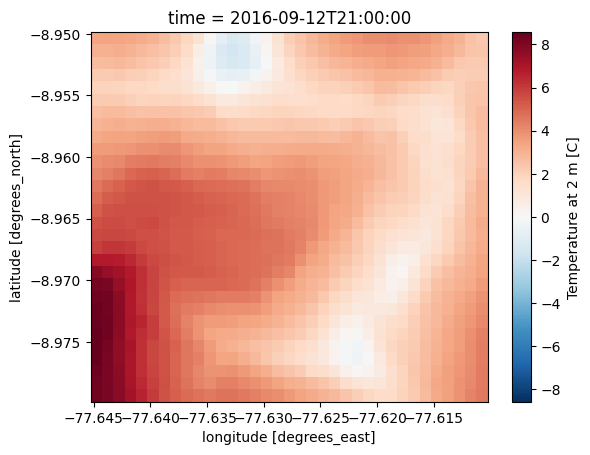

In [15]:
dso['T2'].sel(time='2016-09-12T21').plot()

In [16]:
lapse_RRR =  (0.10/100) # % / m

In [17]:
RRR = df_aws_2016.RRR.values

In [18]:
RRR_interp   = np.zeros([len(dso.time), len(ds_sta.lat), len(ds_sta.lon)])


In [19]:
for t in range(len(dso.time)):
    RRR_interp[t,:,:] = np.where(RRR[t] > 0, RRR[t] + (ds_sta.HGT.values - HGT_AWS) * lapse_RRR, 0)

RRR_interp[RRR_interp<0] = 0

In [20]:
add_variable_along_timelatlon(dso, RRR_interp, 'RRR', 'mm', 'Total precipitation (liquid+solid)')

<xarray.Dataset> Size: 53MB
Dimensions:  (lon: 35, lat: 30, time: 3136)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
  * time     (time) datetime64[ns] 25kB 2016-08-15 ... 2017-09-10T21:00:00
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...
    T2       (time, lat, lon) float64 26MB 5.089 4.94 4.498 ... 2.415 2.201
    RRR      (time, lat, lon) float64 26MB 0.0 0.0 0.0 0.0 ... 0.414 0.483 0.516

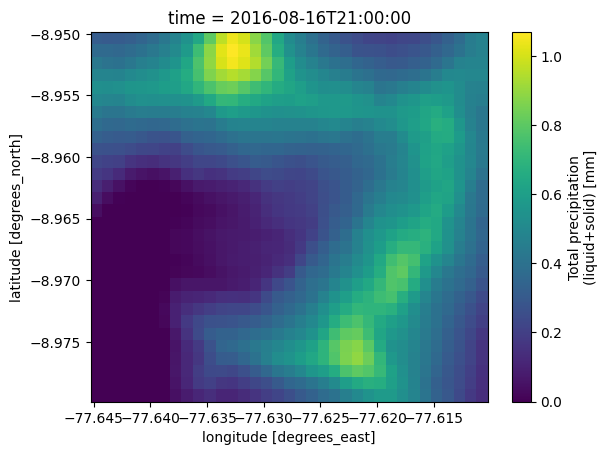

In [21]:
dso['RRR'][15].plot()

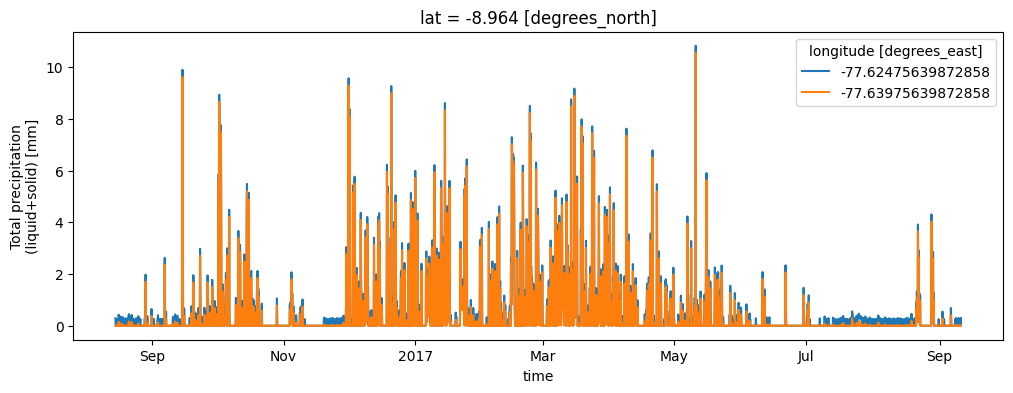

In [22]:
dso.isel(lat=15, lon=[20, -30])['RRR'].plot.line(x='time', figsize=(12, 4))

## Radiacion solar 1D  a 2D

In [23]:
from radCor import correctRadiation

In [24]:
G_interp = np.full([len(dso.time), len(ds_sta.lat), len(ds_sta.lon)], np.nan)

In [25]:
# Change aspect to south==0, east==negative, west==positive
aspect = ds_sta['ASPECT'].values - 180.0
ds_sta['ASPECT'] = (('lat','lon'),aspect)

# Auxiliary variables
mask = ds_sta.MASK.values
slope = ds_sta.SLOPE.values
aspect = ds_sta.ASPECT.values
lats = ds_sta.lat.values
lons = ds_sta.lon.values
sw = df_aws_2016.SWin.values

# Time zone
timezone_lon = -77.6391
# Zenit threshold (>threshold == zenit)
zeni_thld = 85.0

In [26]:
for t in range(len(dso.time)):
    doy = df_aws_2016.index[t].dayofyear
    hour = df_aws_2016.index[t].hour
    for i in range(len(ds_sta.lat)):
        for j in range(len(ds_sta.lon)):
            if (mask[i, j] == 1):
                G_interp[t,i,j] = np.maximum(0.0, correctRadiation(lats[i],lons[j], timezone_lon, doy, hour, slope[i,j], aspect[i,j], sw[t], zeni_thld))


In [27]:
add_variable_along_timelatlon(dso, G_interp, 'G', 'W m\u207b\xb2', 'Incoming shortwave radiation')

<xarray.Dataset> Size: 79MB
Dimensions:  (lon: 35, lat: 30, time: 3136)
Coordinates:
  * lon      (lon) float64 280B -77.64 -77.64 -77.64 ... -77.61 -77.61 -77.61
  * lat      (lat) float64 240B -8.979 -8.978 -8.977 ... -8.952 -8.951 -8.95
  * time     (time) datetime64[ns] 25kB 2016-08-15 ... 2017-09-10T21:00:00
Data variables:
    HGT      (lat, lon) float32 4kB ...
    ASPECT   (lat, lon) float32 4kB ...
    SLOPE    (lat, lon) float32 4kB ...
    MASK     (lat, lon) float32 4kB ...
    T2       (time, lat, lon) float64 26MB 5.089 4.94 4.498 ... 2.415 2.201
    RRR      (time, lat, lon) float64 26MB 0.0 0.0 0.0 0.0 ... 0.414 0.483 0.516
    G        (time, lat, lon) float64 26MB nan nan nan nan ... nan nan nan nan

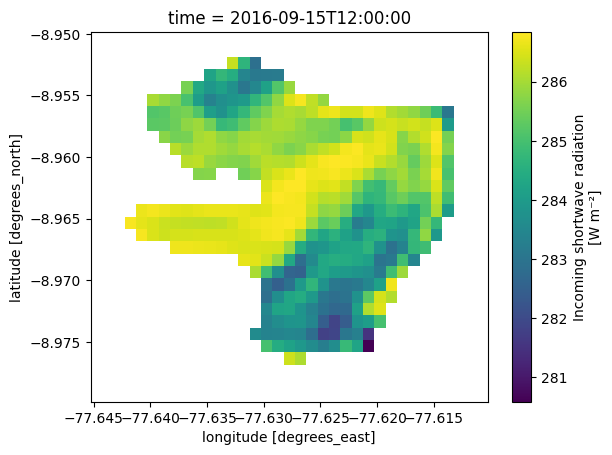

In [28]:
dso['G'].sel(time='20160915T12').plot()

## Adicionar las variables en el netcdf

## Visualizar los datos

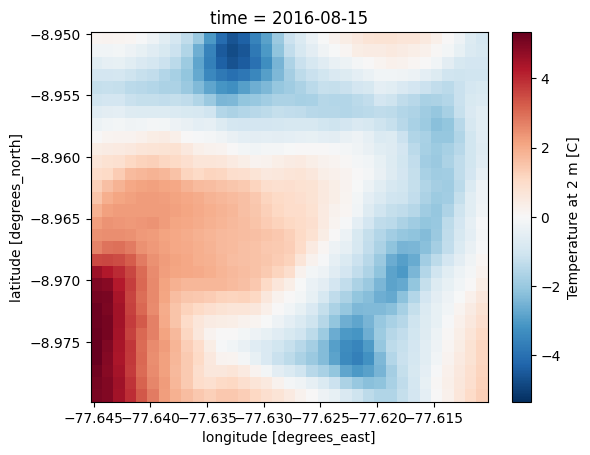

In [29]:
dso.T2[0,:,:].plot()

In [30]:
dso.RRR.max()

<xarray.DataArray 'RRR' ()> Size: 8B
array(11.64900003)

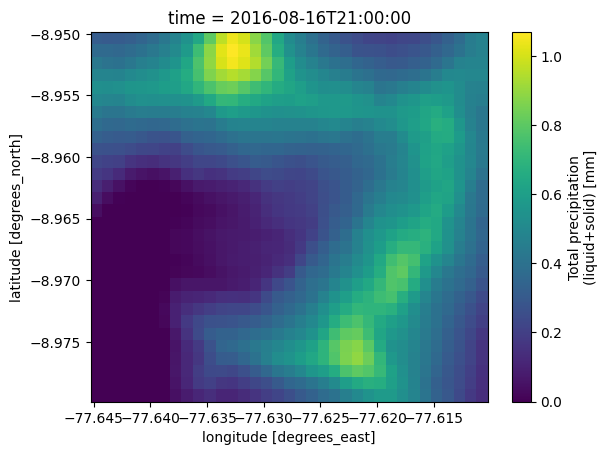

In [31]:
dso.RRR[15,:,:].plot()

## Guardar el netcdf

In [32]:
dso.to_netcdf('../data/AWS_input_AG_G.nc')